##  Before to start ##
 This notebook contains yolov5 model training,detection and validation proccess.

 The goal of the project: recognize target objects and mark them by bounding box 2D(BB). This project is based on drone view object detection. The training dataset also collected images taken by drones.
**NOTE** that, the dataset was collected using various platforms (i.e from open source datasets, manually collected), in different scenarios, and under various weather and lighting conditions, background images were also included. 
 Detection classes: car, van, truck, bus, person

## Verify CUDA ##

In [ ]:
!nvidia-smi

Thu Feb  2 01:57:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    29W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Install yolov5 and dependencies #

In [ ]:
VERSION='v6.0' ## 'v5.0','v6.1'
!git clone  https://github.com/ultralytics/yolov5 # clone
%cd yolov5
!pip install -r requirements.txt  # install

Cloning into 'yolov5'...
remote: Enumerating objects: 15002, done.
remote: Total 15002 (delta 0), reused 0 (delta 0), pack-reused 15002
Receiving objects: 100% (15002/15002), 14.02 MiB | 8.04 MiB/s, done.
Resolving deltas: 100% (10291/10291), done.
/content/yolov5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 84.8 MB/s eta 0:00:00


## Google drive mounting ##
Connect the Colab to  Google Drive for data transfering and save to pretrained models

In [ ]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

/content
Mounted at /content/gdrive


In [ ]:
# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

### Make dataset folder ###

In [ ]:
import os.path
from os import path

if path.exists('/content/dataset') == False:
  os.mkdir('/content/dataset')

os.chdir('/content/dataset')
!pwd
!ls

/content/dataset


## Copying  dataset from drive into root directory of cloud VM ## 
We have already created a custom dataset which is located on Google Drive, there are around 9k images (aerial images taken by drone)  and respective labels (.txt file for each image)

In [ ]:
#!cp <file to download> <destination to save file> 
# e.x ! cp/mydrive/yolov5/data.zip /content/
!cp /mydrive/yolov5/data.zip /content/

### Unziping data on the dataset directory ###

In [ ]:
!unzip data.zip  -d /content/dataset/

## Directory structure ##



---




In this section our data folder (data is dataset)

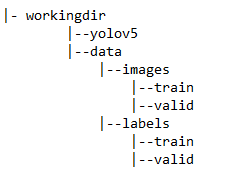

## Data splitting #
### If data and labels were not splitted separately, we can use a helper python script to will place data in the directory structure as shown below ###

In [ ]:
import os
HOME=os.getcwd()
print(HOME)

In [ ]:
%cd {HOME}
!python data_split.py 

## Configure custom YAML file ##
Before starting the model training, we create some specific files that contain data locations , hyperparameters settings and other tunings

file location
```
content/yolov5/data/custom_data.yaml
```
# custom_data.yaml extension
```
# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
path: ../dataset/data  # dataset root dir
train: images/train  # train images (relative to 'path')  8022 images
val: images/valid  # val images (relative to 'path')  500 images
test: images/test  # test images (optional)  100 images

# Classes
names:
  0: car
  1: van
  2: truck
  3: bus
  4: person
```



## For enable augmentation stage  and auto anchor settings ,we have to reinstall some specific dependencies ## 

In [ ]:
!pip uninstall opencv_python_headless
!pip install opencv-python-headless==4.5.4.60

## Save weights to gdrive  ##
weight files 'best.pt' and 'last.pt' save to **mydrive/yolov5/backup** automatice during the training!!!

## Start training proccess ##
  ### We focused to deploy trained model on jetson device so choosed more complex yolov5n model for training . ###

*   We focused to deploy trained model on jetson device so choosed yolov5n model for training .
*   Training starts yolov5n.pt (standart pretrained weights which already trained by COCO dataset) 



*   cfg (Configuration) file also will be set **yolov5n.yaml** 



In [ ]:
! python train.py   --cfg yolov5n.yaml --batch 16 --epochs 100 --data_custom.yaml --weights yolov5n.pt  --project '/mydrive/yolov5' --name 'backup' 

## Evaulate trained Yolov5 performance ##

In [ ]:
!python val.py --weights /content/gdrive/MyDrive/yolov5_lp/backup2/weights/best.engine --batch 1 --data data.yaml --workers 4

val: data=/content/yolov5/data/data.yaml, weights=['/content/gdrive/MyDrive/yolov5_lp/backup2/weights/best.engine'], batch_size=1, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=4, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-56-gc0ca1d2 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (A100-SXM4-40GB, 40536MiB)

Loading /content/gdrive/MyDrive/yolov5_lp/backup2/weights/best.engine for TensorRT inference...
[01/06/2023-05:32:21] [TRT] [I] [MemUsageChange] Init CUDA: CPU +0, GPU +0, now: CPU 0, GPU 648 (MiB)
[01/06/2023-05:32:21] [TRT] [I] Loaded engine size: 8 MiB
[01/06/2023-05:32:21] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in engine deserialization: CPU +0, GPU +0, now: CPU 0, GPU 0 (MiB)
[01/06/2023-05:32:21] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in IExecutionContext creatio

In [ ]:
!python val.py --batch 16 --data data_custom.yaml  --weights  /mydrive/yolov5/backup/weights/best.pt 

val: data=/content/yolov5/data/data.yaml, weights=['/content/gdrive/MyDrive/yolov5_lp/backup2/weights/best.pt'], batch_size=16, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=speed, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-56-gc0ca1d2 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (A100-SXM4-40GB, 40536MiB)

Fusing layers... 
YOLOv5n summary: 157 layers, 1768636 parameters, 0 gradients, 4.2 GFLOPs
val: Scanning /content/dataset/data/validation.cache... 88 images, 0 backgrounds, 0 corrupt: 100% 88/88 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 6/6 [00:01<00:00,  3.32it/s]
                   all         88        204      0.821      0.786      0.821      0.668
                   car         88         76      0.798      0.855      0.888    

In [ ]:
%cd /content/yolov5/
!python detect.py  --source /mydrive/images/test --weights /mydrive/yolov5/backup6/weights/best_04_07_1.pt --conf-thres=0.3 --line-thickness=1  

/content/yolov5
detect: weights=['/mydrive/yolov5/backup6/weights/best_04_07_1.pt'], source=/mydrive/images/test, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.3, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=1, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-72-g064365d Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5l summary: 367 layers, 46129818 parameters, 0 gradients
image 1/6 /content/gdrive/My Drive/images/test/frame_20190905142119_x_0001030.jpg: 384x640 19 cars, 1 truck, 35.0ms
image 2/6 /content/gdrive/My Drive/images/test/highway2.jpg: 384x640 25 cars, 2 vans, 1 truck, 34.8ms
image 3/6 /content/gdrive/My Drive/images/test/test11.jpg: 384x640 1 truck, 2 persons, 23.2ms
image 4/6 /c

## Inferencing sample test images ##

/content/yolov5/runs/detect/exp4/highway2.jpg


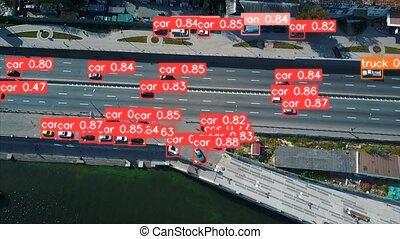



/content/yolov5/runs/detect/exp4/test5.jpg


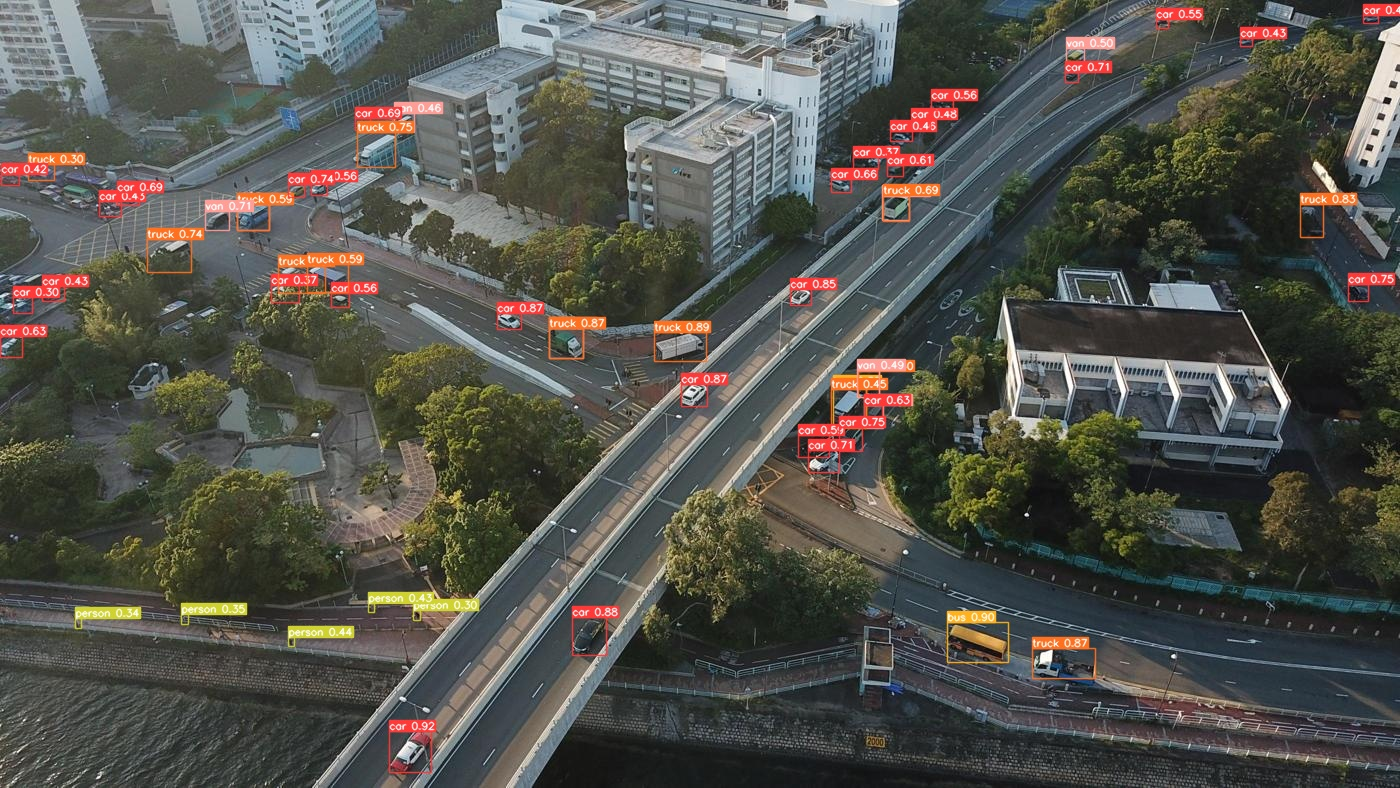



/content/yolov5/runs/detect/exp4/test3.jpg


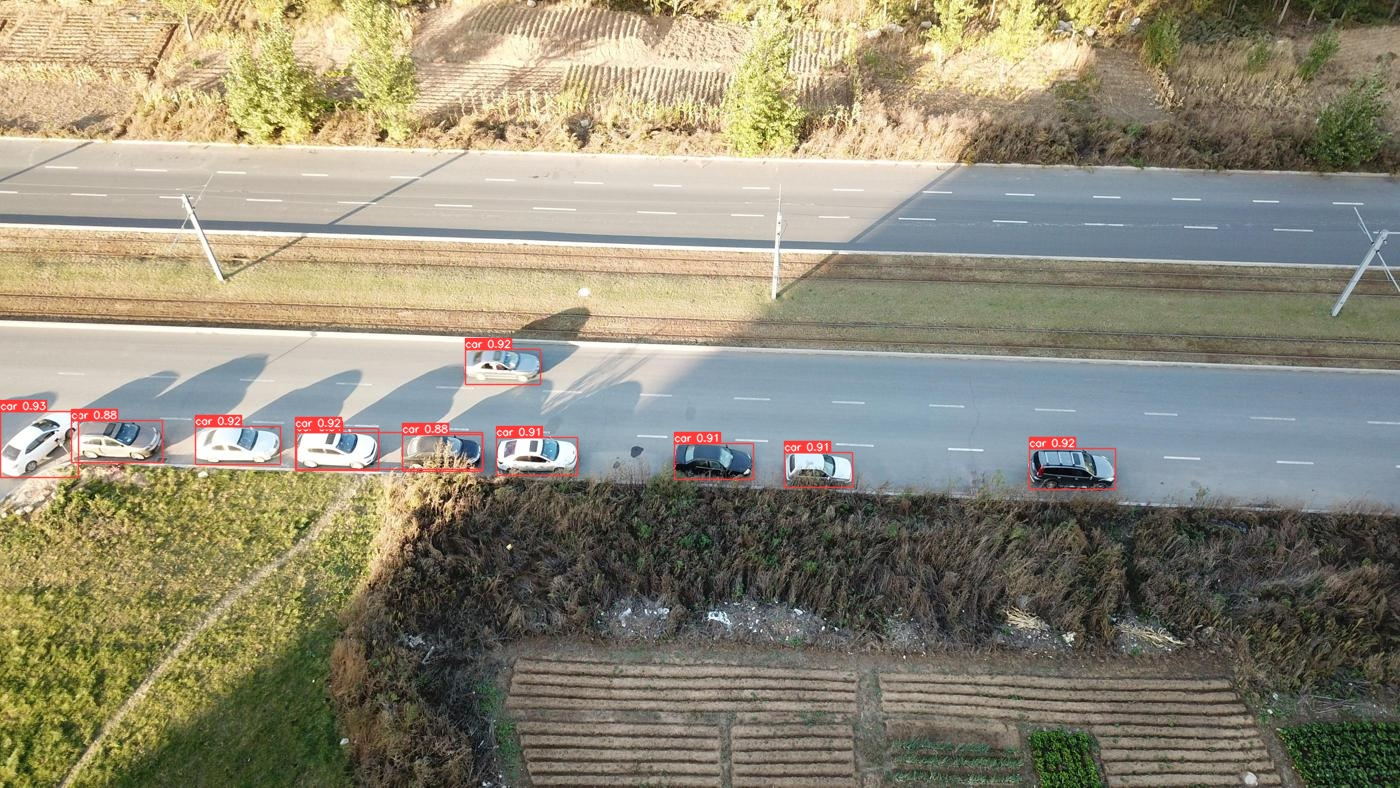



/content/yolov5/runs/detect/exp4/test222.jpg


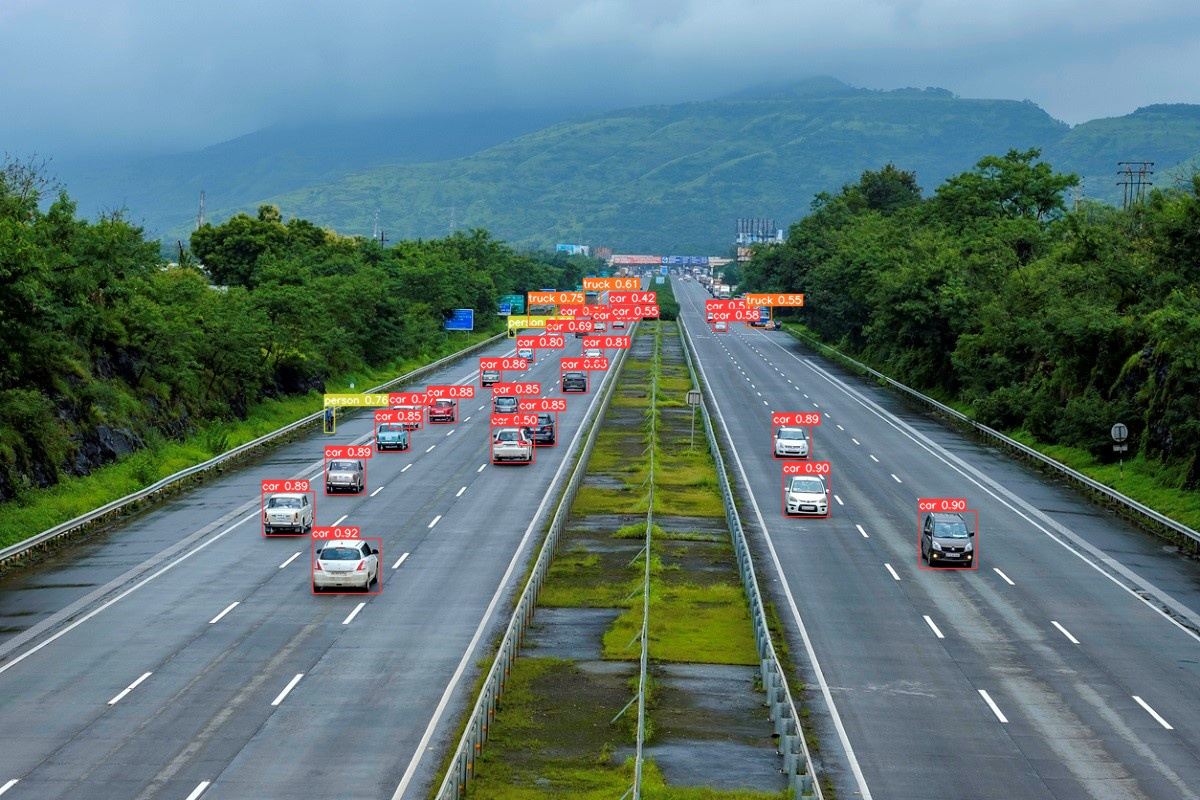



/content/yolov5/runs/detect/exp4/frame_20190905142119_x_0001030.jpg


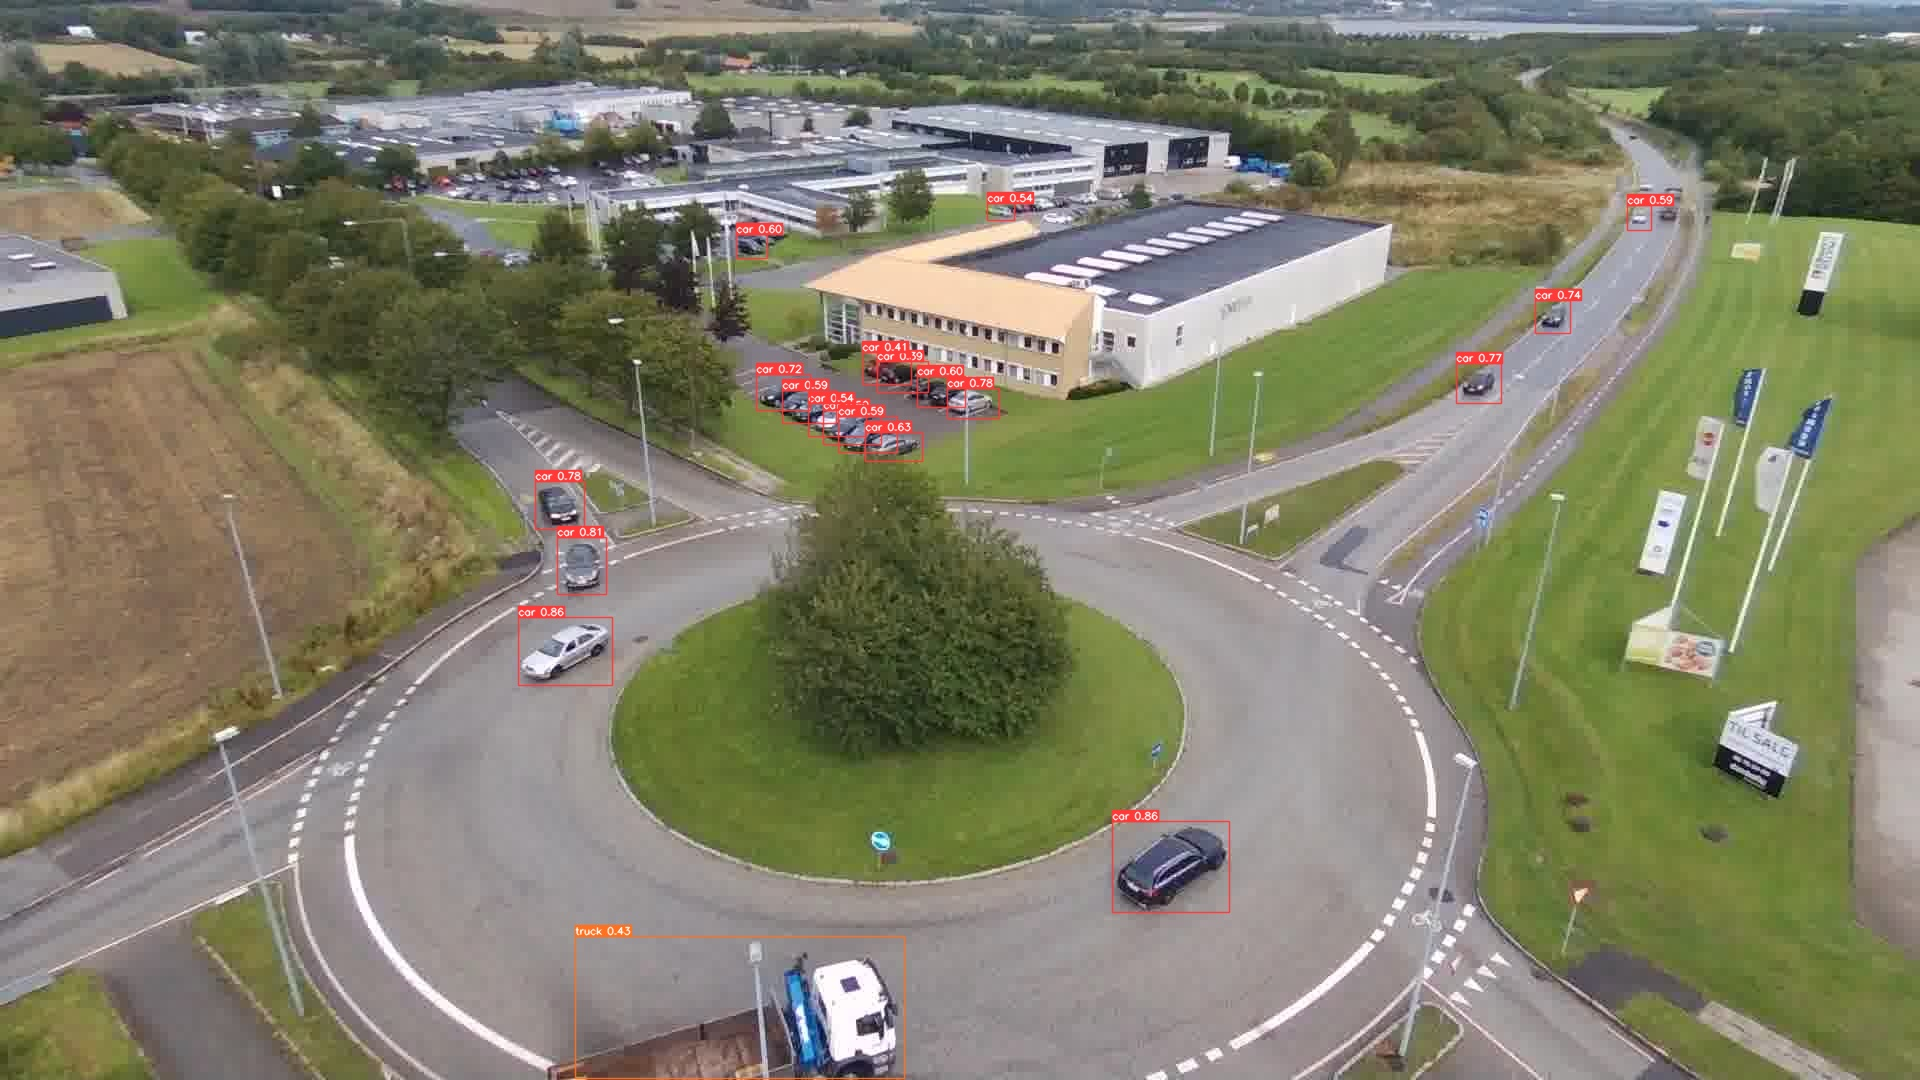



/content/yolov5/runs/detect/exp4/test11.jpg


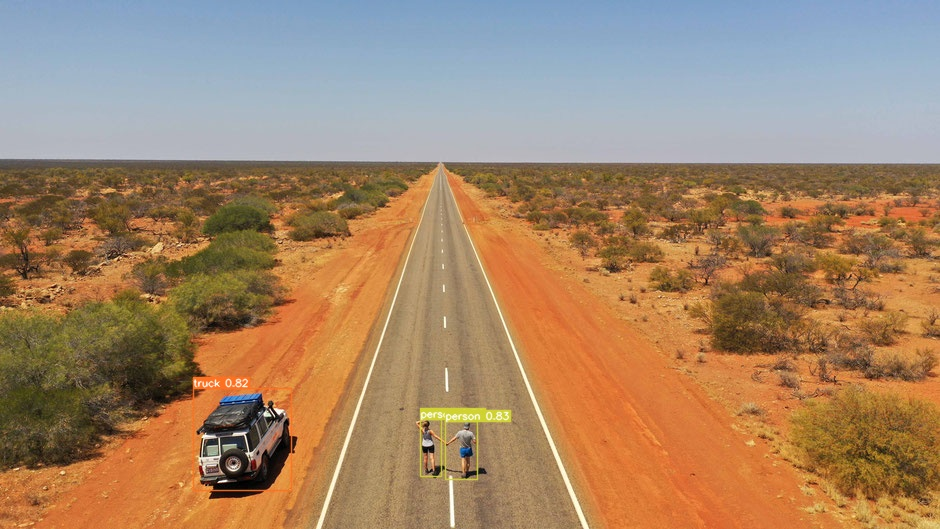

In [ ]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp4/*.jpg'): #assuming JPG
    print(imageName) 
    display(Image(filename=imageName))
    print("\n")

## Converting pretrained models to TensorRt format ##

In [ ]:
!pip install nvidia-tensorrt

In [ ]:
!python export.py --data data.yaml --batch-size=1 --weights /mydrive/yolov5/backup/weights/best.pt --include engine --device 0

export: data=data.yaml, weights=['/content/gdrive/MyDrive/yolov5_lp/backup2/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=0, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=17, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['engine']
YOLOv5 🚀 v7.0-56-gc0ca1d2 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (A100-SXM4-40GB, 40536MiB)

Fusing layers... 
YOLOv5n summary: 157 layers, 1768636 parameters, 0 gradients, 4.2 GFLOPs

PyTorch: starting from /content/gdrive/MyDrive/yolov5_lp/backup2/weights/best.pt with output shape (1, 25200, 12) (3.7 MB)

ONNX: starting export with onnx 1.13.0...
ONNX: export success ✅ 0.8s, saved as /content/gdrive/MyDrive/yolov5_lp/backup2/weights/best.onnx (7.2 MB)

TensorRT: starting export with TensorRT 8.4.3.1...
[01/06/2023-05:24:40] [TRT] [I] [MemUsageChange] Init CUDA: CPU +0, GPU +0, now: CPU 0, GPU 2012 (

Training proccess can take several hours depend system environment and selected training iterations (epochs).  However, Colab Cloud Service kicks  off it's VMs if you are idle for too long (more than hours).



**TIP:** To avoid this hold **(CTRL + SHIFT + I)**at the same time to open up the inspector view on your browser and put this code, finally  click **ENTER**



```
function ClickConnect(){
    console.log("Clicked on connect button"); 
    document.querySelector("colab-connect-button").click()
}
setInterval(ClickConnect,60000)

```

